In [2]:
#!pip install pyhrv

In [3]:
import spectHR as cs
import pyhrv

In [4]:
DataSet = cs.SpectHRDataset("Example Data/SUB_002.xdf", 1, event_index = 0) 

In [5]:
bDataSet = cs.borderData(DataSet)
bDataSet.ecg = bDataSet.ecg.slicetime(500,2100)

In [6]:
fDataSet = cs.filterECGData(bDataSet, 
                          {'filterType': 'highpass', 
                           'cutoff': 1})

In [7]:
tDataSet = cs.calcPeaks(bDataSet)

In [8]:
%matplotlib widget
GUI = cs.spectplot(tDataSet, 860, 890)

In [9]:
GUI

AppLayout(children=(Dropdown(description='Mode:', layout=Layout(grid_area='header', width='200px'), options=('…

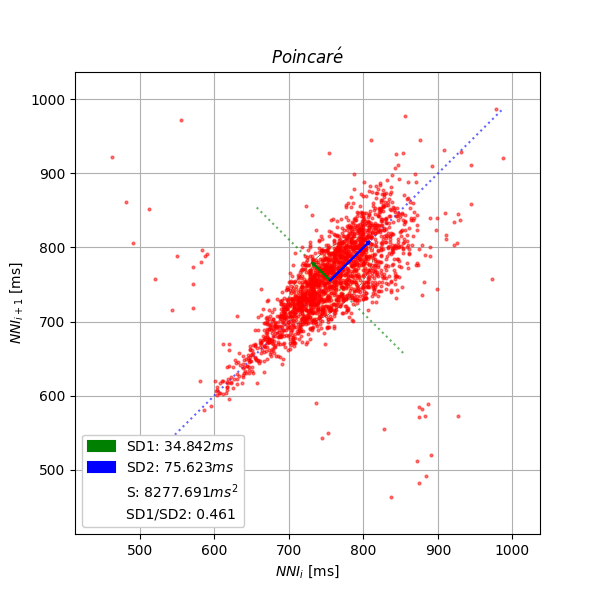

In [10]:
cs.poincare(tDataSet, 0, 1000)

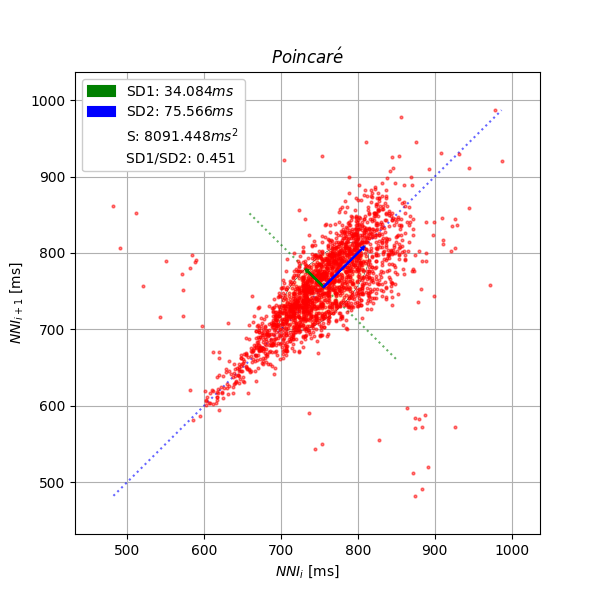

In [21]:
cs.poincare(tDataSet, 0, 1000)

In [23]:
voila

NameError: name 'voila' is not defined